In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### DGRP TE Presence/Absence
Raw data (S.5) from DOI: http://dx.doi.org/10.1093/molbev/mst129

Cridland, Julie M., et al. "Abundance and distribution of transposable elements in two Drosophila QTL mapping resources." Molecular biology and evolution 30.10 (2013): 2311-2327.

_Saved as Supp_table5.tsv_

In [2]:
df = pd.read_csv('Supp_table5.tsv',sep='\t')
print(df.shape) # Verify dimensions match previous version in matlab (17639 x 136)
df.head(3)

(17639, 136)


ID   Ch   Upstream_estimate  Downstream_estimate  \
0   8563   3R            9446915              9446650   
1  28336   2R           13849730             13849725   
2   8434   3L           13893951             13893934   

                                     Type 21 26 40 42 45  ... 879 884 887 890  \
0                           X:non-LTR:RNA  N  N  0  0  0  ...   N   0   0   N   
1  undetermined:undetermined:undetermined  0  0  0  0  0  ...   0   0   0   N   
2                      jockey:non-LTR:RNA  0  0  0  0  0  ...   0   0   0   0   

  892 894 897 907 908 911  
0   0   0   0   0   0   N  
1   0   0   0   N   N   0  
2   0   0   0   0   0   N  

[3 rows x 136 columns]

Replace indeterminate calls (N) with 0 (Absent)

per our manuscript, "Because the vast majority of
TE insertions were determined to be rare (83% are present in only one line), we treated loci with indeterminate calls as absent"

In [3]:
indet = 0
df.replace(to_replace='N', value=indet,inplace=True)

Parse the TE names into three new columns, "name", "family", "type".  Since "undetermined" spans multiple categories, append the type (DNA/RNA) to the name and family columns.

Also note that the categorizations differ qualitatively from the _M. Guttatus_ data

In [4]:
# Split into three new columns
df[['name','family','type']] = df['Type'].str.split(':',expand=True)

# Append the type to name and family (due to "undetermined" spanning multiple categories)
for c in ['name','family']:
    df[c] = df[c] + '(' + df['type'] + ')'
df.head(3)

# Performance warning does not affect results

/tmp/ipykernel_193/243241264.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['name','family','type']] = df['Type'].str.split(':',expand=True)
/tmp/ipykernel_193/243241264.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['name','family','type']] = df['Type'].str.split(':',expand=True)
/tmp/ipykernel_193/243241264.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

ID   Ch   Upstream_estimate  Downstream_estimate  \
0   8563   3R            9446915              9446650   
1  28336   2R           13849730             13849725   
2   8434   3L           13893951             13893934   

                                     Type 21 26 40 42 45  ... 890 892 894 897  \
0                           X:non-LTR:RNA  0  0  0  0  0  ...   0   0   0   0   
1  undetermined:undetermined:undetermined  0  0  0  0  0  ...   0   0   0   0   
2                      jockey:non-LTR:RNA  0  0  0  0  0  ...   0   0   0   0   

  907 908 911                        name                      family  \
0   0   0   0                      X(RNA)                non-LTR(RNA)   
1   0   0   0  undetermined(undetermined)  undetermined(undetermined)   
2   0   0   0                 jockey(RNA)                non-LTR(RNA)   

           type  
0           RNA  
1  undetermined  
2           RNA  

[3 rows x 139 columns]

Exclude Chromosome 4

per our manuscript, "chromosome 4 was excluded from this analysis; it is known to have a number of peculiar features, including being very small and known not to recombine"

In [5]:
#Exclude chr 4
idx4 = df[' Ch '] == '4'
print(sum(idx4)) # Verify number of rows dropped matches old matlab version (98 rows)
df = df[~idx4].copy()

98


---
### Create summary by TE name

In [6]:
# Drop all columns except name and count
cols2drop = ['ID ', ' Ch ', 'Upstream_estimate','Downstream_estimate','Type']
te_by_name = df.drop(columns=[*cols2drop,'family','type'])

# Convert data to integers
for c in te_by_name.columns:
    if c != 'name':
        te_by_name[c] = te_by_name[c].astype(int)
# Group by name and sum
te_by_name = te_by_name.groupby(by='name').sum()
# Output as csv
te_by_name.to_csv('DMel_TE_SummaryByName.csv')
# Preview results
te_by_name.head(3)

21  26  40  42  45  49  57  59  69  73  ...  879  884  887  890  \
name                                               ...                       
1360(DNA)   1   2   4   2   3   3   3   2   2   1  ...    1    4    2    3   
17.6(RNA)   1   0   1   0   0   0   2   2   1   0  ...    0    0    2    2   
1731(RNA)   0   0   0   0   0   0   0   0   0   0  ...    0    0    0    0   

           892  894  897  907  908  911  
name                                     
1360(DNA)    2    1    3    2    4    2  
17.6(RNA)    1    0    2    4    2    3  
1731(RNA)    1    0    0    0    0    0  

[3 rows x 131 columns]

In [7]:
# Check mean, variance and Fano factors
mean_by_name = te_by_name.mean(axis=1)
print('Mean copy number:')
print(mean_by_name)
var_by_name = te_by_name.var(axis=1)
print('\nSample variance:')
print(var_by_name)
print('\nFano factors:')
fano_by_name = var_by_name/mean_by_name
print(fano_by_name)
print('\nMean Fano factor:')
print(np.mean(fano_by_name))

Mean copy number:
name
1360(DNA)                      2.320611
17.6(RNA)                      1.167939
1731(RNA)                      0.083969
297(RNA)                       1.305344
3S18(RNA)                      1.404580
                                ...    
transib2(DNA)                  0.641221
transib3(DNA)                  1.267176
undetermined(DNA)              0.290076
undetermined(RNA)             15.419847
undetermined(undetermined)    89.580153
Length: 93, dtype: float64

Sample variance:
name
1360(DNA)                        1.081033
17.6(RNA)                        1.279272
1731(RNA)                        0.077510
297(RNA)                         1.429125
3S18(RNA)                        2.381210
                                 ...     
transib2(DNA)                    0.231826
transib3(DNA)                    1.858837
undetermined(DNA)                0.284439
undetermined(RNA)               39.814680
undetermined(undetermined)    2197.291603
Length: 93, dtype: float6

---
### Create summary by TE "family"

In [8]:
# Drop all columns except family and count
te_by_fam = df.drop(columns=[*cols2drop,'name','type'])

# Convert data to integers
for c in te_by_fam.columns:
    if c != 'family':
        te_by_fam[c] = te_by_fam[c].astype(int)
# Group by family and sum
te_by_fam = te_by_fam.groupby(by='family').sum()
# Output as csv
te_by_fam.to_csv('DMel_TE_SummaryByFamily.csv')
# Preview results
te_by_fam.head(3)

21  26   40  42  45  49   57  59  69  73  ...  879  884  887  \
family                                                   ...                  
LTR(RNA)       76  82  143  97  81  53  160  65  94  74  ...   32   81   78   
TIR(DNA)       47  60   70  42  48  44   72  42  57  32  ...   33   55   50   
foldback(DNA)   4   4   10   4   5   9    7   5   9   4  ...    6    6    8   

               890  892  894  897  907  908  911  
family                                            
LTR(RNA)        82  130   78  129   51  115   63  
TIR(DNA)        50   58   50   66   56   61   40  
foldback(DNA)    3    5    9   11    6    7    6  

[3 rows x 131 columns]

In [9]:
# Check mean, variance and Fano factors
mean_by_fam = te_by_fam.mean(axis=1)
print('Mean copy number:')
print(mean_by_fam)
var_by_fam = te_by_fam.var(axis=1)
print('\nSample variance:')
print(var_by_fam)
print('\nFano factors:')
fano_by_fam = var_by_fam/mean_by_fam
print(fano_by_fam)
print('\nMean Fano factor:')
print(np.mean(fano_by_fam))

Mean copy number:
family
LTR(RNA)                      79.648855
TIR(DNA)                      53.801527
foldback(DNA)                  6.526718
non-LTR(RNA)                  40.458015
undetermined(DNA)              0.068702
undetermined(RNA)              8.358779
undetermined(undetermined)    89.580153
dtype: float64

Sample variance:
family
LTR(RNA)                       805.291133
TIR(DNA)                       132.591075
foldback(DNA)                    7.097358
non-LTR(RNA)                   249.896301
undetermined(DNA)                0.064474
undetermined(RNA)               16.108749
undetermined(undetermined)    2197.291603
dtype: float64

Fano factors:
family
LTR(RNA)                      10.110517
TIR(DNA)                       2.464448
foldback(DNA)                  1.087431
non-LTR(RNA)                   6.176682
undetermined(DNA)              0.938462
undetermined(RNA)              1.927165
undetermined(undetermined)    24.528777
dtype: float64

Mean Fano factor:
6.74764046

---
### Create summary by TE type

In [10]:
# Drop all columns except type and count
te_by_type = df.drop(columns=[*cols2drop,'name','family'])

# Convert data to integers
for c in te_by_type.columns:
    if c != 'type':
        te_by_type[c] = te_by_type[c].astype(int)
# Group by type and sum
te_by_type = te_by_type.groupby(by='type').sum()
# Output as csv
te_by_type.to_csv('DMel_TE_SummaryByType.csv')
# Preview
te_by_type.head(3)

21   26   40   42   45   49   57  59   69   73  ...  879  884  \
type                                                           ...             
DNA            51   64   80   46   54   53   79  48   66   36  ...   39   61   
RNA           128  130  233  131  119  103  215  99  150  114  ...   48  119   
undetermined  110   96  129   69   80   76  466  75  124   80  ...   47   66   

              887  890  892  894  897  907  908  911  
type                                                  
DNA            58   53   63   60   77   62   68   46  
RNA           117  130  201  125  204   75  169   99  
undetermined   69  106   98   71  115   46  112   58  

[3 rows x 131 columns]

In [11]:
# Check mean, variance and Fano factors
mean_by_type = te_by_type.mean(axis=1)
print('Mean copy number:')
print(mean_by_type)
var_by_type = te_by_type.var(axis=1)
print('\nSample variance:')
print(var_by_type)
print('\nFano factors:')
fano_by_type = var_by_type/mean_by_type
print(fano_by_type)
print('\nMean Fano factor:')
print(np.mean(fano_by_type))

Mean copy number:
type
DNA              60.396947
RNA             128.465649
undetermined     89.580153
dtype: float64

Sample variance:
type
DNA              164.041221
RNA             2053.312272
undetermined    2197.291603
dtype: float64

Fano factors:
type
DNA              2.716052
RNA             15.983357
undetermined    24.528777
dtype: float64

Mean Fano factor:
14.4093950993784


---
### Create map of TE categories

In [12]:
te_name_map = df[['type','family','name']].drop_duplicates()
te_name_map.to_csv('TENameMap.csv',index=False)
te_name_map

type                      family                        name
0               RNA                non-LTR(RNA)                      X(RNA)
1      undetermined  undetermined(undetermined)  undetermined(undetermined)
2               RNA                non-LTR(RNA)                 jockey(RNA)
4               RNA                    LTR(RNA)                    roo(RNA)
5               RNA                    LTR(RNA)               Stalker2(RNA)
...             ...                         ...                         ...
13546           RNA                non-LTR(RNA)                 TART-B(RNA)
13777           RNA                    LTR(RNA)               invader6(RNA)
14660           RNA                    LTR(RNA)                   Tom1(RNA)
16955           DNA                    TIR(DNA)                looper1(DNA)
17472           DNA                    TIR(DNA)               mariner2(DNA)

[96 rows x 3 columns]

In [13]:
# Verify undetermined type implies undetermined family implies undetermined name (but not vice-versa)
idx = te_name_map['name'].str.contains('undetermined')
sum(idx)
te_name_map[idx]

type                      family                        name
1    undetermined  undetermined(undetermined)  undetermined(undetermined)
12            RNA           undetermined(RNA)           undetermined(RNA)
77            RNA                    LTR(RNA)           undetermined(RNA)
151           RNA                non-LTR(RNA)           undetermined(RNA)
215           DNA                    TIR(DNA)           undetermined(DNA)
271           DNA           undetermined(DNA)           undetermined(DNA)

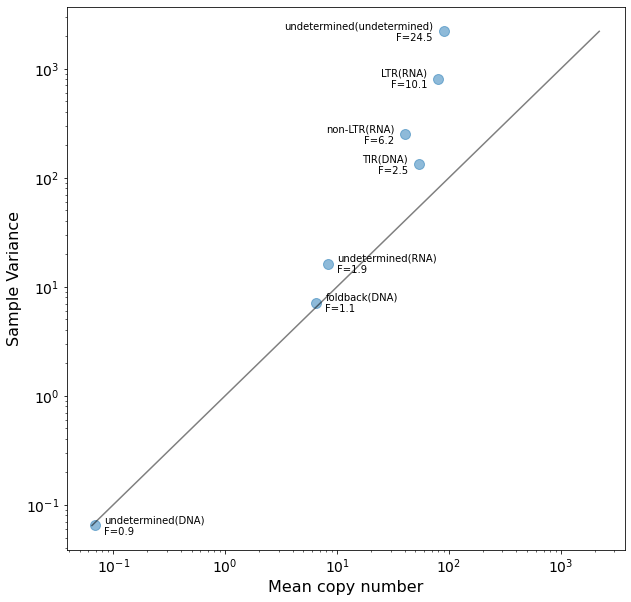

In [14]:
# Validate plot

tmeans = mean_by_fam
tvars = var_by_fam
tfano = fano_by_fam

# Font sizes
TICKS = 14
LABELS = 16
TEXT = 10

plt.figure(figsize=(10,10))
# Data
plt.scatter(tmeans, tvars, s=100, alpha=0.5)

# Reference line
mmin = min(min(tmeans), min(tvars))
mmax = max(max(tmeans), max(tvars))
plt.plot([mmin,mmax], [mmin,mmax],'-k', alpha=0.5)

# Label points
for i,f in enumerate(tmeans.index):
    if tmeans.iloc[i] < 10:
        ha='left'
        offset = 1.2
    else:
        ha='right'
        offset=0.8
    plt.text(tmeans.iloc[i]*offset, 
             tvars.iloc[i], 
             f + '\nF=' + format(tfano[i],'.1f'),
             ha = ha,
             va = 'center',
             fontsize=TEXT
             )

plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.xlabel('Mean copy number',fontsize=LABELS)
plt.ylabel('Sample Variance',fontsize=LABELS)
plt.show()